In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats


In [7]:
#Read the excel file
#Note this file was cleaned in AWS using SQL
df = pd.read_excel(r'C:\Users\U2BT\Documents\CX Case Study\Unique_Client_Events_Final.xlsx')

In [8]:
#Define Column Names for the Data Frame:
df.columns = ['Client_ID', 'Variation', 'Visitor_ID', 'Visit_ID', 'Client_Tenure_Yrs', 'Client_Tenure_Months', 'Client_Age', 'Client_Gender',
'Num_Accounts', 'Balance', 'Calls_6_Months', 'Logons_6_Months',
'Num_Visitor_ID', 'Num_Visit_ID', 'Process_Step', 'Start_Date',
'Drop_Off_Step', 'Drop_Off_Date', 'Complete_Step', 'Complete_Date', 'Confirm_Flag']

In [9]:
#Quick Data Cleanup
#Since there are Nulls in the Confirm_Flag column, replace the Nulls with 0.
df["Confirm_Flag"].fillna(0, inplace = True)

In [10]:
#Preview the first Few Lines of Data
df.head()

,Client_ID,Variation,Visitor_ID,Visit_ID,Client_Tenure_Yrs,Client_Tenure_Months,Client_Age,Client_Gender,Num_Accounts,Balance,...,Logons_6_Months,Num_Visitor_ID,Num_Visit_ID,Process_Step,Start_Date,Drop_Off_Step,Drop_Off_Date,Complete_Step,Complete_Date,Confirm_Flag
0,7338123,Test,612065484_94198474375,100019538_17884295066_43909,7.0,88.0,23.0,M,2.0,26436.0,...,9.0,3,3,start,2017-04-09 16:20:56,confirm,2017-04-09 16:24:58,confirm,2017-04-09 16:24:58,1.0
1,2478628,Test,754122351_18568832435,100022086_87870757897_149620,16.0,198.0,47.0,F,2.0,32456.0,...,5.0,1,1,start,2017-05-23 20:44:01,confirm,2017-05-23 20:47:01,confirm,2017-05-23 20:47:01,1.0
2,105007,Control,676020267_36602664238,100030127_47967100085_936361,9.0,118.0,35.0,F,2.0,34897.0,...,6.0,1,1,start,2017-03-22 11:07:49,start,2017-03-22 11:07:49,NaN,NaT,0.0
3,4823947,Control,611052344_43146965242,100057941_88477660212_944512,7.0,86.0,52.0,U,2.0,47340.0,...,8.0,1,1,start,2017-04-09 11:30:10,step_3,2017-04-09 11:34:24,NaN,NaT,0.0
4,1748647,NaN,413751600_31279009983,100061345_677868293_127105,21.0,260.0,72.0,F,2.0,145799.0,...,3.0,1,1,start,2017-04-04 06:57:49,start,2017-04-04 06:57:49,NaN,NaT,0.0


In [11]:
#Review the length of rows in Dataset
#Should be 70609 to represent how many people are in the experimental dataset.
df['Client_ID'].nunique()

70609

In [13]:
#Drop the "Nulls" in the Variation Column so that there are only Test and Control Variations
df_nonull = df[pd.notnull(df['Variation'])]

In [14]:
#New number of rows in the dataset should be 50500
df_nonull['Client_ID'].nunique()

50500

In [16]:
#Convert the Start_Date column into a datetime column so that it can be filtered:
df_nonull['Start_Date'] = pd.to_datetime(df_nonull['Start_Date'])

C:\Progra~1\Anaconda3_4\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [18]:
#Filter the Starting Date of Website Activity to the experiemental testing Dates of March 15th-April 30
df_date = df_nonull[(df_nonull['Start_Date'] > '2017-03-14') & (df_nonull['Start_Date'] < '2017-05-01')]

In [19]:
df_date['Client_ID'].nunique()

40028

In [20]:
#Quick Scan to see the differences in means by each experimental group:
df_date.groupby('Variation').mean()

,Client_ID,Client_Tenure_Yrs,Client_Tenure_Months,Client_Age,Num_Accounts,Balance,Calls_6_Months,Logons_6_Months,Num_Visitor_ID,Num_Visit_ID,Confirm_Flag
Variation,,,,,,,,,,,
Control,5.023261e+06,12.094826,151.157062,47.548998,2.264490,152986.964413,3.098323,6.135909,1.142714,1.433028,0.542603
Test,5.004994e+06,12.005180,150.133957,47.222975,2.251965,151698.496978,3.054028,6.093697,1.128288,1.427838,0.581111


In [21]:
#Find the overall completion Rate
(df_date.query('Confirm_Flag == 1').Confirm_Flag.count())/df_date.shape[0]

0.56378035375237334

In [86]:
#Construct the Contingency Table for the Variation and Confirm_Flag
contingency_table = pd.crosstab(df_date['Variation'], df_date['Confirm_Flag'],margins = True)

In [87]:
#This formats the data into a frequency count table
#using the crosstab function in pandas
contingency_table

Confirm_Flag,0.0,1.0,All
Variation,,,
Control,8240,9775,18015
Test,9221,12792,22013
All,17461,22567,40028


In [88]:
#Run P-Value test to determine if there is a significant relationship sample stats
#Defining get_pvalue function below:
def get_pvalue(con_conv, test_conv, con_size, test_size):
    lift = -abs(test_conv - con_conv)
    
    scale_one = con_conv * (1-con_conv) * (1/ con_size)
    scale_two = test_conv * (1-test_conv) * (1/ test_size)
    scale_val = (scale_one + scale_two) ** 0.5
    
    p_value = 2 * stats.norm.cdf(lift, loc=0, scale = scale_val)
    
    return p_value

In [89]:
# Testing the p-value:
con_conv = 0.54260339
test_conv = 0.58111116
con_size = 18015
test_size = 22012
get_pvalue(con_conv, test_conv, con_size, test_size)
#Given the sample size there is a significant difference in the completion rate

1.1004552306379254e-14

In [90]:
import seaborn as sns
import matplotlib.pyplot as plt

In [91]:
#Assigns the frequency values
controlcount = contingency_table.iloc[0][0:2].values
testcount = contingency_table.iloc[1][0:2].values

In [41]:
#First, let's put the observed values into a one dimensional array, reading the contingency table from left to right then top to bottom.
f_obs = np.append(contingency_table.iloc[0][0:2].values, contingency_table.iloc[1][0:2].values)
f_obs

array([ 8240,  9775,  9221, 12792], dtype=int64)

In [42]:
row_sums = contingency_table.iloc[0:2,2].values
row_sums

array([18015, 22013], dtype=int64)

In [43]:
col_sums = contingency_table.iloc[2,0:2].values
col_sums

array([17461, 22567], dtype=int64)

In [45]:
total = contingency_table.loc['All', 'All']
f_expected = []

for j in range(2):
    for i in col_sums:
        f_expected.append(i*row_sums[j]/total)
f_expected

[7858.4969271509945,
 10156.503072849006,
 9602.5030728490055,
 12410.496927150994]

In [46]:
chi_squared_statistic = ((f_obs - f_expected)**2/f_expected).sum()
print('Chi-squared Statistic: {}'.format(chi_squared_statistic))

Chi-squared Statistic: 59.735336264589264


In [47]:
dof = (len(row_sums)-1)*(len(col_sums)-1)
print("Degrees of Freedom: {}".format(dof))

Degrees of Freedom: 1


In [48]:
#The cut off for a p-value of 0.05 is 3.841.
#Our X2 statistic was so large that the p-value is approximately zero.
#So we have evidence against the null hypothesis

In [49]:
f_obs = np.array([contingency_table.iloc[0][0:2].values,
contingency_table.iloc[1][0:2].values])
f_obs

array([[ 8240,  9775],
       [ 9221, 12792]], dtype=int64)

In [50]:
from scipy import stats
stats.chi2_contingency(f_obs)[0:3]

(59.578859958669469, 1.1749048329309977e-14, 1)

In [52]:
##Perform the same Chi-Squared Test for the Drop Off Step and Variation Group:
##First Contingency Table is created:
contingency_table2 = pd.crosstab(df_date['Variation'], df_date['Drop_Off_Step'], margins = True)

In [53]:
#Show Drop Step Contingency Table:
contingency_table2

Drop_Off_Step,confirm,start,step_1,step_2,step_3,All
Variation,,,,,,
Control,9242,4687,1525,1034,1527,18015
Test,12597,5532,1818,895,1171,22013
All,21839,10219,3343,1929,2698,40028


In [54]:
#Assigns the frequency values
controlcount2 = contingency_table2.iloc[0][1:5].values
testcount2 = contingency_table2.iloc[1][1:5].values

In [55]:
#Puts Observations from Contingency table into an Array
f_obs2 = np.array([contingency_table2.iloc[0][1:5].values,
contingency_table2.iloc[1][1:5].values])
f_obs2

array([[4687, 1525, 1034, 1527],
       [5532, 1818,  895, 1171]], dtype=int64)

In [56]:
#Run Chi-Squared Test Statistic for the Drop Step:
stats.chi2_contingency(f_obs2)[0:3]

(129.97436144394939, 5.4777042194820374e-28, 3)

In [57]:
#Create Pivot Table of Confirm and
summary= df_date.pivot_table(values='Confirm_Flag', index='Variation', aggfunc
='sum')
summary

,Confirm_Flag
Variation,
Control,9775.0
Test,12792.0


In [58]:
# add additional columns to the pivot table
summary['Total Attempts'] = df_date.pivot_table(values='Confirm_Flag', index='Variation', aggfunc=lambda x: len(x))
summary['Confirmation Rate'] = df_date.pivot_table(values='Confirm_Flag', index='Variation')

In [59]:
summary

,Confirm_Flag,Total Attempts,Confirmation Rate
Variation,,,
Control,9775.0,18015.0,0.542603
Test,12792.0,22013.0,0.581111


In [ ]:
##Below code is used to calculate Bayesian Statistics:

In [60]:
from scipy.stats import beta

In [61]:
##This imports the calc_prob.py library:

from math import lgamma
from numba import jit
#defining the functions used
@jit
def h(a, b, c, d):
    num = lgamma(a + c) + lgamma(b + d) + lgamma(a + b) + lgamma(c + d)
    den = lgamma(a) + lgamma(b) + lgamma(c) + lgamma(d) + lgamma(a + b + c + d)
    return np.exp(num - den)

@jit
def g0(a, b, c):
    return np.exp(lgamma(a + b) + lgamma(a + c) - (lgamma(a + b + c) + lgamma(a)))

@jit
def hiter(a, b, c, d):
    while d > 1:
        d -= 1
        yield h(a, b, c, d) / d

def g(a, b, c, d):
    return g0(a, b, c) + sum(hiter(a, b, c, d))

def calc_prob_between(beta1, beta2):
    return g(beta1.args[0], beta1.args[1], beta2.args[0], beta2.args[1])

In [64]:
#This is the known data: total sample grouping and website confirmation rate for the Control and Test set
imps_ctrl,convs_ctrl=18015, 54
imps_test, convs_test=22013, 58
#here we create the Beta functions for the two sets
a_C, b_C = convs_ctrl+1, imps_ctrl-convs_ctrl+1
beta_C = beta(a_C, b_C)
a_T, b_T = convs_test+1, imps_test-convs_test+1
beta_T = beta(a_T, b_T)
#calculating the lift
lift=(beta_T.mean()-beta_C.mean())/beta_C.mean()
#calculating the probability for Control to be better than Test
prob=calc_prob_between(beta_C, beta_T)
print (f"Test option lift Conversion Rates by {lift*100:2.2f}% with {prob*100:2.1f}% probability.")

Test option lift Conversion Rates by -12.21% with 75.5% probability.


In [68]:
import matplotlib.pyplot as plt
def calc_beta_mode(a, b):
    #'''this function calculate the mode (peak) of the Beta distribution'''
    return (a-1)/(a+b-2)

In [71]:
def plot(betas, names, linf=0, lsup=0.01):
    #'''this function plots the Beta distribution'''
    x=np.linspace(linf,lsup, 100)
    for f, name in zip(betas,names) :
        y=f.pdf(x) #this for calculate the value for the PDF at the specified x-points

        y_mode=calc_beta_mode(f.args[0], f.args[1])
        y_var=f.var() # the variance of the Beta distribution
        plt.plot(x,y, label=f"{name} sample, conversion rate: {y_mode:0.1E} $\pm$ {y_var:0.1E}")
        plt.yticks([])
    plt.legend()
    plt.show()

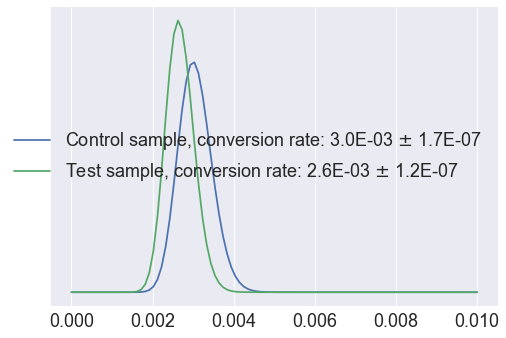

In [72]:
plot([beta_C, beta_T], names=["Control", "Test"])